In [1]:
# import sys
# sys.path.append('..')

In [1]:
import portpy.photon as pp
import numpy as np
import os

In [2]:
data_dir = r'D:\MyJupyter\RL_BAO\Data'
data = pp.DataExplorer(data_dir=data_dir)
data.display_list_of_patients()

,patient_id,disease_site,ptv_vol_cc,num_beams
0,Lung_Patient_6,Lung,87.487,72
1,Lung_Patient_7,Lung,177.273,72


In [3]:
data.patient_id = 'Lung_Patient_6'
# user can get the results back in the panda dataframe format by using the arguments 'return_beams_df' and 'return_structs_df'
beams_df, structs_df = data.display_patient_metadata(return_beams_df=True, return_structs_df=True)
beams_df.head(3)

,ID,gantry_angle,collimator_angle,couch_angle,beam_modality,energy_MV,influence_matrix(sparse/full),iso_center,MLC_name,machine_name
0,0,0,0,0,Photon,6,Both,"{'x_mm': -55.73869, 'y_mm': -225.023, 'z_mm': ...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
1,1,5,0,0,Photon,6,Both,"{'x_mm': -55.73869, 'y_mm': -225.023, 'z_mm': ...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
2,2,10,0,0,Photon,6,Both,"{'x_mm': -55.73869, 'y_mm': -225.023, 'z_mm': ...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM


In [7]:
structs_df.head(10)

,name,volume_cc
0,GTV,12.078503
1,PTV,87.487200
2,ESOPHAGUS,56.720140
3,HEART,678.150940
4,LUNG_L,1617.267330
5,LUNG_R,2155.674560
6,CORD,70.874350
7,SKIN,1.000000
8,BODY,25635.246100


In [4]:
ct = pp.CT(data)
structs = pp.Structures(data)
a = [i for i in range(0,30)]
beams = pp.Beams(data, beam_ids=a)
# By default, PortPy uses the beams selected by an expert planner, which are included as part of the dataset. 
# However, you can pass your own selection of beams as an argument. For instance, to use beams with the ids 0, 10, 20, 30, 40
# you would construct your Beams object like this: beams = pp.Beams(data, beam_ids=[0,10,20,30,40]).

In [5]:
protocol_name = 'Lung_2Gy_30Fx'
clinical_criteria = pp.ClinicalCriteria(data, protocol_name=protocol_name)

In [6]:
# Loading hyper-parameter values for optimization problem
opt_params = data.load_config_opt_params(protocol_name=protocol_name)
# Creating optimization structures (i.e., Rinds) 
structs.create_opt_structures(opt_params=opt_params, clinical_criteria=clinical_criteria)
# Loading influence matrix
inf_matrix = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)

creating rinds.. This step may take some time due to dilation
Optimization structures created!!
Creating BEV..
Loading sparse influence matrix...
Done


In [7]:
my_plan = pp.Plan(ct = ct, structs = structs, beams = beams, inf_matrix = inf_matrix, clinical_criteria=clinical_criteria)

opt = pp.Optimization(my_plan, opt_params=opt_params, clinical_criteria=clinical_criteria)
opt.create_cvxpy_problem()
# solve the cvxpy problem using Mosek
sol = opt.solve(solver='MOSEK', verbose=False)

Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 39.62258354110074
Elapsed time: 325.670241355896 seconds


<Axes: xlabel='x-axis (beamlets column)', ylabel='y-axis (beamlets row)'>

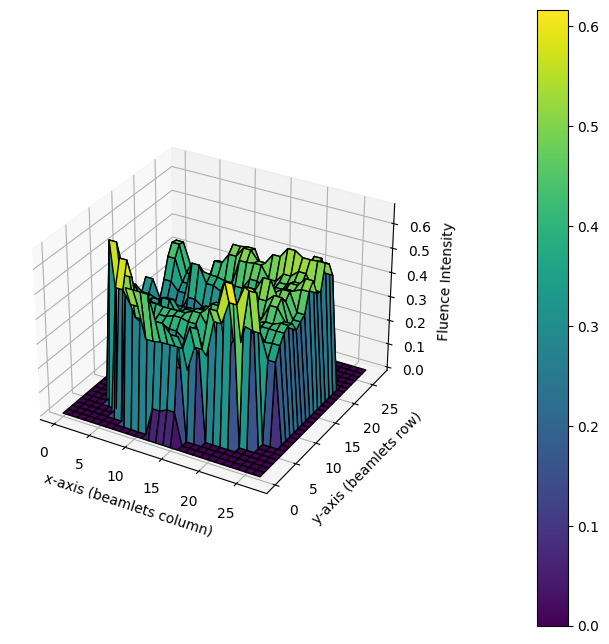

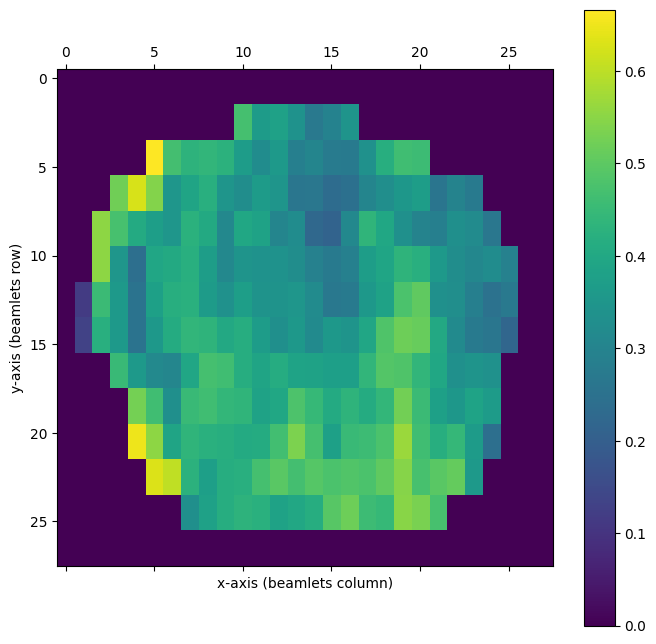

In [8]:
pp.Visualization.plot_fluence_3d(sol=sol, beam_id=my_plan.beams.get_all_beam_ids()[0])

pp.Visualization.plot_fluence_2d(sol=sol, beam_id=my_plan.beams.get_all_beam_ids()[0])


<Axes: title={'center': 'Lung_Patient_6'}, xlabel='Dose (Gy)', ylabel='Volume Fraction (%)'>

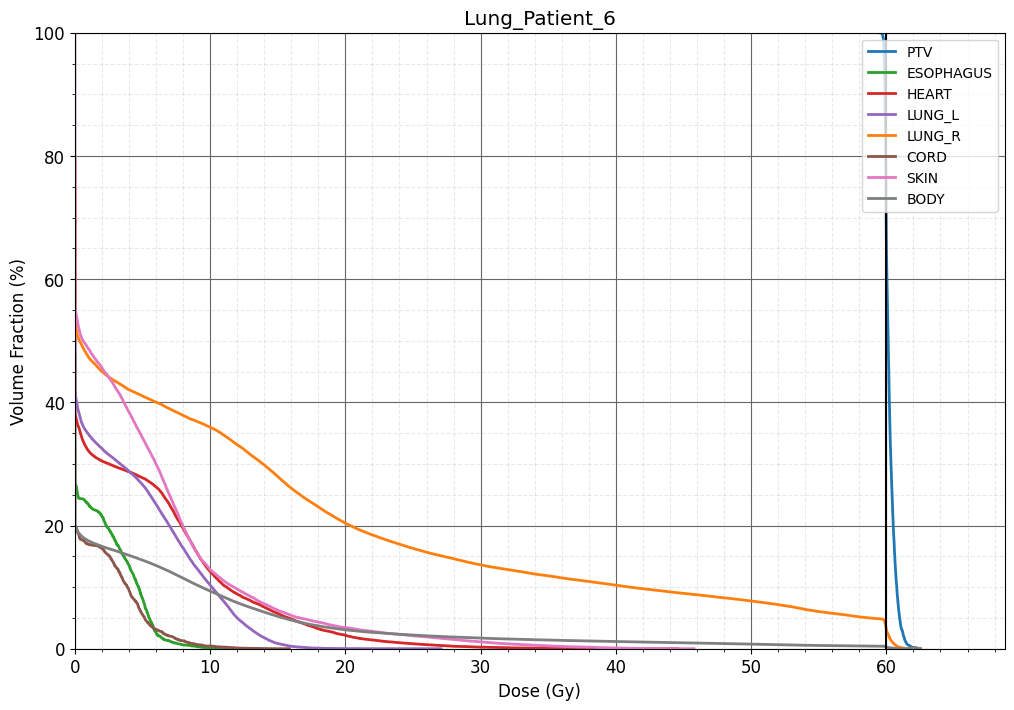

In [9]:
# Default dose_1d is in Gy and volume is in relative scale(%).
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'LUNG_L', 'LUNG_R', 'CORD', 'SKIN', 'BODY']

# plot dvh for the above structures
pp.Visualization.plot_dvh(my_plan, sol=sol, struct_names=struct_names, title=data.patient_id)


<Axes: title={'center': 'Axial View - Slice #: 60'}>

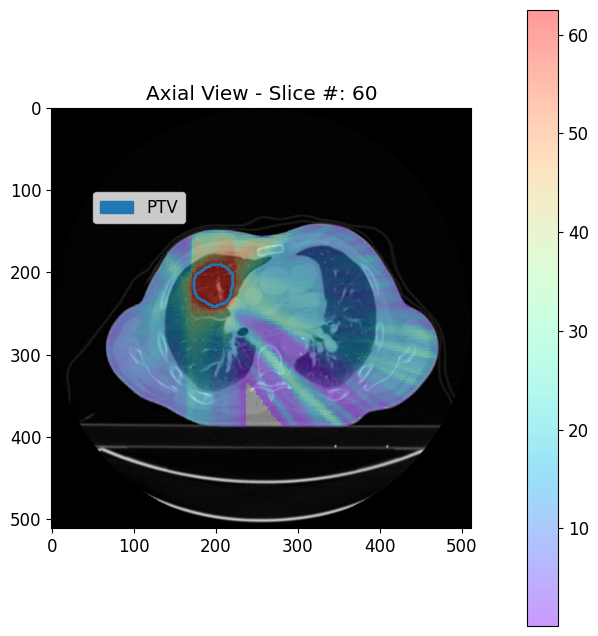

In [15]:
pp.Visualization.plot_2d_slice(my_plan=my_plan, sol=sol, slice_num=60, struct_names=['PTV'])

In [16]:
# visualize plan metrics and compare them against the clinical criteria
pp.Evaluation.display_clinical_criteria(my_plan, sol=sol, clinical_criteria=clinical_criteria)
# The Evaluation class also has methods to extract different DVH metrics (e.g., get_dose(sol, struct, volume_per), get_volume(sol: struct dose_value_gy)))


,name,parameters,constraints,Plan Value
0,max_dose,{'structure_name': 'GTV'},"{'limit_dose_gy': 69, 'goal_dose_gy': 66}",61.330035
1,max_dose,{'structure_name': 'PTV'},"{'limit_dose_gy': 69, 'goal_dose_gy': 66}",62.501624
2,max_dose,{'structure_name': 'ESOPHAGUS'},{'limit_dose_gy': 66},12.634059
3,mean_dose,{'structure_name': 'ESOPHAGUS'},"{'limit_dose_gy': 34, 'goal_dose_gy': 21}",1.014493
4,dose_volume_V,"{'structure_name': 'ESOPHAGUS', 'dose_gy': 60}",{'limit_volume_perc': 17},0.000000
5,max_dose,{'structure_name': 'HEART'},{'limit_dose_gy': 66},44.550871
6,mean_dose,{'structure_name': 'HEART'},"{'limit_dose_gy': 27, 'goal_dose_gy': 20}",3.297504
7,dose_volume_V,"{'structure_name': 'HEART', 'dose_gy': 30}",{'limit_volume_perc': 50},0.255063
8,dose_volume_V,"{'structure_name': 'HEART', 'dose_gy': 30}",{'goal_volume_perc': 48},0.255063
9,max_dose,{'structure_name': 'LUNG_L'},{'limit_dose_gy': 66},27.063922


In [17]:
#dose_1d: 将dose从三维展成一维
for p, s in enumerate([sol]):
    dose_1d = s['inf_matrix'].A @ (s['optimal_intensity'] * my_plan.get_num_of_fractions())
dose_1d

array([0., 0., 0., ..., 0., 0., 0.])

In [19]:
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'LUNG_L', 'LUNG_R', 'CORD', 'SKIN', 'BODY']
struct_names_id = 1
x, y = pp.Evaluation.get_dvh(sol=sol, struct=struct_names[struct_names_id], dose_1d = dose_1d)
print(x,y)
print(len(x))
j = 500
print(x[j] == 0)
print(y[0],y[j])


[ 0.          0.          0.         ... 12.40099436 12.63405877
 12.64405877] [4.73393400e-01 4.73347093e-01 4.72976640e-01 ... 9.26134012e-05
 4.63067006e-05 0.00000000e+00]
1514
True
0.4733934 0.31539493763083504


In [20]:
inf_matrix = sol['inf_matrix']
# vox: struct_names[i] 的体素id （相对于dose_1d）
vox = inf_matrix.get_opt_voxels_idx(struct_names[struct_names_id])
org_sort_dose = np.sort(dose_1d[vox])
# org_sort_dose = np.append(org_sort_dose, org_sort_dose[-1] + 0.01)
print(vox)
print(dose_1d)
print(len(dose_1d))
print(org_sort_dose)
# x = org_sort_dose

[  4094   4095   4096 ... 313418 313419 313420]
[0. 0. 0. ... 0. 0. 0.]
317307
[ 0.          0.          0.         ... 12.14107282 12.40099436
 12.63405877]


In [21]:
x

array([ 0.        ,  0.        ,  0.        , ..., 12.40099436,
       12.63405877, 12.64405877])

In [22]:
# sort_ind: 获取vox（体素id）对应从小到大排列的dose的索引
sort_ind = np.argsort(dose_1d[vox])
# 返回 struct_names[i]的体素体积(cc: cm^3)列表
org_weights = inf_matrix.get_opt_voxels_volume_cc(struct_names[struct_names_id])
# org_sort_weights: 获取 x = org_sort_dose 对应的体素体积大小列表
org_sort_weights = org_weights[sort_ind]
sum_weight = np.sum(org_sort_weights)
print(sort_ind)
print(org_weights)
print(org_sort_weights)
print(sum_weight)

[   0 1289 1290 ...  870 1171 1178]
[0.0028812 0.0115248 0.0230496 ... 0.0172872 0.014406  0.0057624]
[0.0028812 0.0230496 0.0028812 ... 0.0057624 0.0028812 0.0028812]
29.4545076


In [23]:
len(org_sort_weights)

1513

In [28]:
# Get fraction of volume in calc box(?) for the struct_name
frac_vol = inf_matrix.get_fraction_of_vol_in_calc_box(struct_names[struct_names_id])
if frac_vol is None:
    y = [1]
else:
    y = [frac_vol]
for j in range(len(org_sort_weights)):
    y.append(y[-1] - (org_sort_weights[j] / sum_weight)*frac_vol)
print(frac_vol)
print(y[-10:])

# 计算逻辑错误! 需先判断y的下一个数值对应的dose是否和前一个相同
# 如果相同, 比如dose均为0，则

0.4733934
[0.0012502809155879734, 0.0009724407121251934, 0.0005556804069310234, 0.00041676030519963343, 0.00037045360462250346, 0.0003241469040453735, 0.00018522680231398348, 9.26134011597235e-05, 4.6306700582593505e-05, 5.463511587588954e-15]


In [43]:
import math
def dvh_function(x , org_sort_weights, frac_vol):
    # the all volume weight
    sum_weight_all = np.sum(org_sort_weights) / frac_vol
    weight_not_in_calc_box = sum_weight_all - np.sum(org_sort_weights)
    x_new  = np.insert(x, 0, 0)
    org_sort_weights_new = np.insert(org_sort_weights, 0, weight_not_in_calc_box)
    unique_x, id_x = np.unique(x_new, return_inverse = True)
    unique_weights = np.bincount(id_x, weights = org_sort_weights_new)

    y = [1]
    for j in range(len(unique_weights)):
        y.append(y[-1] - unique_weights[j] / sum_weight_all)
    
    max_dose_list = []
    for i in range(len(struct_names)):
        m = pp.Evaluation.get_max_dose(sol = sol, struct = struct_names[i], dose_1d=dose_1d)
        max_dose_list.append(m)
    max_dose_dvh = math.ceil(max(max_dose_list))
    
    unique_x = np.append(unique_x, max_dose_dvh)
    y[-1] = 0
    
    f = interpolate.interp1d(unique_x, y)
    return f

In [33]:
max_dose = np.zeros(8)
X = []
DVH = []
for i in range(0, len(struct_names)):
    max_dose[i] = pp.Evaluation.get_max_dose(sol = sol, struct = struct_names[i], dose_1d=dose_1d)
    x, y = pp.Evaluation.get_dvh(sol=sol, struct=struct_names[i], dose_1d = dose_1d)
    X.append(x)
    DVH.append(y)
print(X)
print(DVH)
DVH[3][-1]

[array([59.44665399, 59.47141979, 59.51360948, ..., 62.42957052,
       62.50162433, 62.51162433]), array([ 0.        ,  0.        ,  0.        , ..., 12.40099436,
       12.63405877, 12.64405877]), array([ 0.        ,  0.        ,  0.        , ..., 43.96172212,
       44.55087125, 44.56087125]), array([ 0.        ,  0.        ,  0.        , ..., 24.81829013,
       27.06392235, 27.07392235]), array([ 0.        ,  0.        ,  0.        , ..., 62.42957052,
       62.50162433, 62.51162433]), array([ 0.        ,  0.        ,  0.        , ..., 14.3697299 ,
       15.84615737, 15.85615737]), array([ 0.        ,  0.        ,  0.        , ..., 45.51238884,
       45.76097621, 45.77097621]), array([ 0.        ,  0.        ,  0.        , ..., 62.42957052,
       62.50162433, 62.51162433])]
[array([1.00000000e+00, 9.99906896e-01, 9.99875861e-01, ...,
       5.58624542e-04, 2.79312271e-04, 0.00000000e+00]), array([4.73393400e-01, 4.73347093e-01, 4.72976640e-01, ...,
       9.26134012e-05, 4.6306

0.0

In [41]:
X[1][:-1]

array([ 0.        ,  0.        ,  0.        , ..., 12.14107282,
       12.40099436, 12.63405877])

In [44]:
f = dvh_function(X[1][:-1], org_sort_weights, frac_vol)

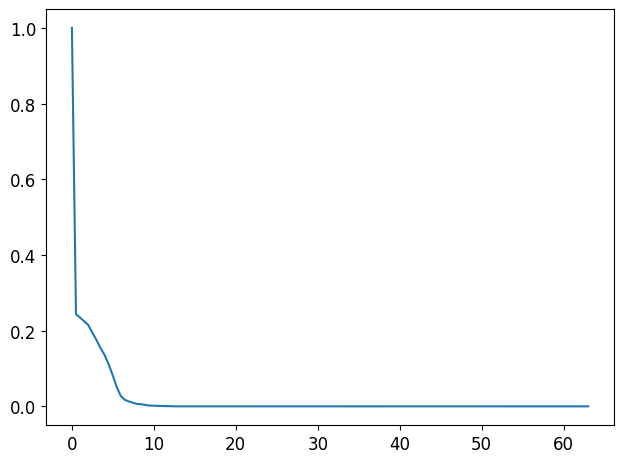

In [46]:
x_plot = np.linspace(0,63,128)
y_plot = f(x_plot)
plt.plot(x_plot, y_plot)

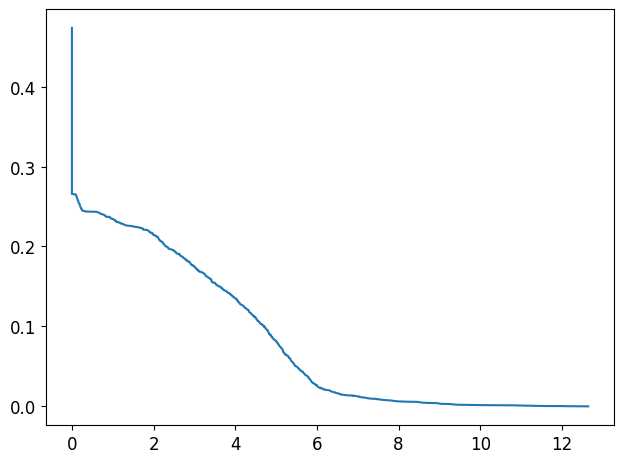

In [31]:
import matplotlib.pyplot as plt
id = 1
plt.plot(X[id], DVH[id])

In [19]:
# Comment/Uncomment these lines to save and load the pickle file for plans and optimal solution from the directory
pp.save_plan(my_plan, plan_name='my_plan_phantom.pkl', path=os.path.join(r'C:\temp', data.patient_id))
pp.save_optimal_sol(sol, sol_name='sol_phantom.pkl', path=os.path.join(r'C:\temp', data.patient_id))
# my_plan = pp.load_plan(plan_name='my_plan_phantom.pkl', path=os.path.join(r'C:\temp', data.patient_id))
# sol = pp.load_optimal_sol(sol_name='sol_phantom.pkl', path=os.path.join(r'C:\temp', data.patient_id))